In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import welch
from scipy.optimize import curve_fit

In [2]:
def get_psd(data, channel=1):
    fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
    nperseg = fs / 10
    
    ff, pp = welch(data[channel], fs=fs, nperseg=nperseg)
    return ff, pp

In [3]:
def get_peak_area(data, channel=1, fdrive=20000):
    """Integrate to get the area under a driven peak"""
    ff, pp = get_psd(data, channel=channel)
    
    peak_idx = int(fdrive / 10)
    lb, ub = peak_idx-10, peak_idx+10
    
    all_idx = np.arange(lb, ub, 1)
    excluding_peak = np.logical_or(all_idx < (peak_idx-3), all_idx > (peak_idx+3))

    area_all = np.trapz(pp[all_idx], ff[all_idx]*2*np.pi)
    area_excluding_peak = np.trapz( pp[all_idx[excluding_peak]], ff[all_idx[excluding_peak]]*2*np.pi )

    # Excluding background contribution (which is very small anyway)
    # Take care of 2 pi normalization after numerical integration
    # because we integrated over omega here
    v2_drive = (area_all - area_excluding_peak) / (2 * np.pi)
    
    return v2_drive

In [4]:
def peak_func(x, amp, omega_0, gamma):
    """A Lorentzian line shape"""
    return amp * gamma / ( ( omega_0**2 - x**2)**2 + gamma**2 * x**2 )

def fit_peak(x, y, peak_func, p0=None):
    popt, pcov = curve_fit(peak_func, x, y, p0=p0)
    
    # Return central frequency and gamma
    return popt, x, peak_func(x, *popt)

## Fit the Lorentzian peak from displacement noise

In [26]:
data_file = r"D:\Experiment\Calibration\20230913\noefield_1s_lp.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

Low Pressure - Amplitude: 593284.977495213, central frequency: 38303.83088762641 Hz, gamma: 163.33670969088234 Hz


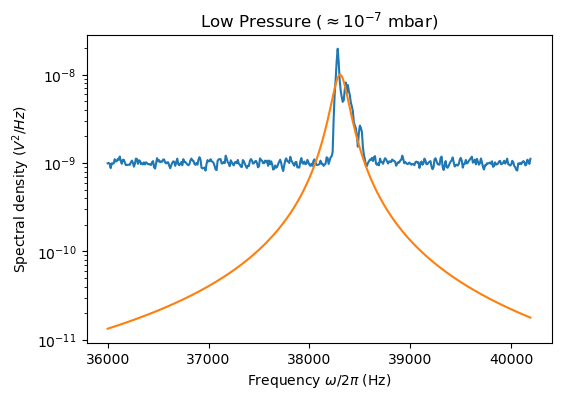

In [29]:
lb, ub = 3600, 4020

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ff[lb:ub], pp[lb:ub])

# Fit with a Lorentzian and plot
popt, omega_fit, p_fit = fit_peak(ff[lb:ub]*2*np.pi, pp[lb:ub], peak_func, p0=[535, 39500*2*np.pi, 500])
ax.plot(omega_fit/(2*np.pi), p_fit)

amp_low, omega0_low, gamma_low = popt[0], popt[1], popt[2]
print(f'Low Pressure - Amplitude: {amp_low}, central frequency: {omega0_low/(2*np.pi)} Hz, gamma: {gamma_low/(2*np.pi)} Hz')

ax.set_title(r'Low Pressure ($\approx 10^{-7}$ mbar)')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)')
ax.set_ylabel('Spectral density ($V^2 / Hz$)')

ax.set_yscale('log')

In [123]:
# Use this value after ethanol is gone
rho = 1800 # kg/m^3
r   = 167e-9 / 2
m   = rho * (4 * np.pi / 3) * r**3 

## Drive the particle with a frequency comb

In [35]:
data_file = r"D:\Experiment\Calibration\20230913\freq_comb_20s_20_70_2khz_lp_0_5vp2p.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

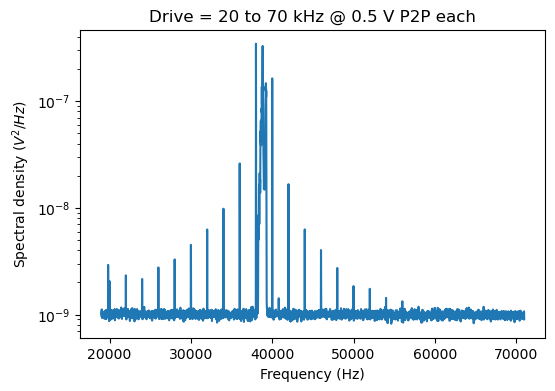

In [38]:
lb, ub = 1900, 7100
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ff[lb:ub], pp[lb:ub])

ax.set_title('Drive = 20 to 70 kHz @ 0.5 V P2P each')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density ($V^2 / Hz$)')

ax.set_yscale('log')

In [39]:
drive_amp = 0.5  # peak-to-peak voltage for each freq component in V
freq_comb_file = r"C:\Users\microspheres\Documents\Python Scripts\Experiment Control\freq_comb_20khz_70khz_deltaf2khz.npz"

comb_data = np.load(freq_comb_file, allow_pickle=True)
ff_drive = comb_data['ff']

In [67]:
charge0 = 3 * 1.6e-19
charge_guess = 9 * 1.6e-19  # Coulombs

efield = 250          # V/m when 1 V is applied
amp = drive_amp / 2   # Because what's in the file is the peak-to-peak amplitude and we want the amp from zero

c_cal_square = 68552553774.39739

In [68]:
chisquare = np.zeros_like(ff_drive, dtype=np.float64)
chisquare_guess = np.zeros_like(ff_drive, dtype=np.float64)

f0 = charge0 * amp * efield
fguess = charge_guess * amp * efield

for i, f in enumerate(ff_drive):
    v2_drive = get_peak_area(data, 1, f)
    x2_drive = v2_drive / c_cal_square
    
    chisquare_drive = 2 * x2_drive / (f0**2)
    chisquare_drive_guess = 2 * x2_drive / (fguess**2)
    
    chisquare[i] = chisquare_drive
    chisquare_guess[i] = chisquare_drive_guess

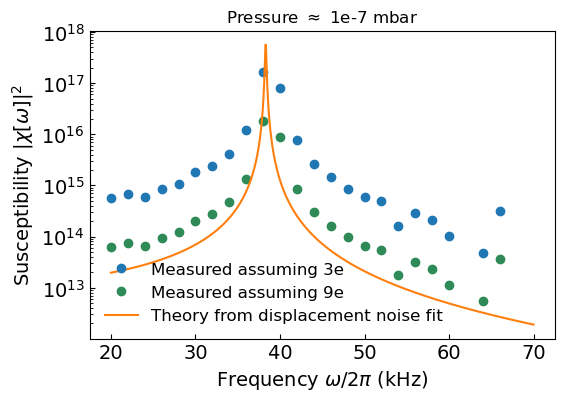

In [72]:
lb, ub = 2000, 7000

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ff_drive/1000, chisquare, 'o', label='Measured assuming 3e')
ax.plot(ff_drive/1000, chisquare_guess, 'o', label='Measured assuming 9e', color='seagreen')

ax.plot(ff[lb:ub]/1000, peak_func(ff[lb:ub]*2*np.pi, 1/(m * m * gamma_low), omega0_low, gamma_low), label='Theory from displacement noise fit')

ax.set_title(r'Pressure $\approx$ 1e-7 mbar')
ax.set_xlabel(r'Frequency $\omega / 2 \pi$ (kHz)', fontsize=14)
ax.set_ylabel(r'Susceptibility $| \chi[\omega] |^2$', fontsize=14)
ax.legend(loc='lower left', frameon=False, fontsize=12)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
ax.set_yscale('log')

## Second round calibration

In [205]:
data_file = r"D:\Experiment\Calibration\20230913\89khzonly_1s_lp_3.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

Low Pressure - Amplitude: 1553316.6563410922, central frequency: 38728.446241417674 Hz, gamma: 67.93300370496284 Hz


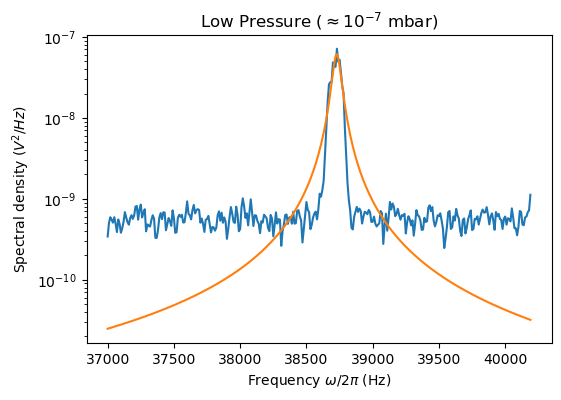

In [206]:
lb, ub = 3700, 4020

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ff[lb:ub], pp[lb:ub])

# Fit with a Lorentzian and plot
popt, omega_fit, p_fit = fit_peak(ff[lb:ub]*2*np.pi, pp[lb:ub], peak_func, p0=[535, 39500*2*np.pi, 500])
ax.plot(omega_fit/(2*np.pi), p_fit)

amp_low, omega0_low, gamma_low = popt[0], popt[1], popt[2]
print(f'Low Pressure - Amplitude: {amp_low}, central frequency: {omega0_low/(2*np.pi)} Hz, gamma: {gamma_low/(2*np.pi)} Hz')

ax.set_title(r'Low Pressure ($\approx 10^{-7}$ mbar)')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)')
ax.set_ylabel('Spectral density ($V^2 / Hz$)')

ax.set_yscale('log')

Inject frequency comb

In [222]:
data_file = r"D:\Experiment\Calibration\20230913\freq_comb_20s_20_70_2khz_lp_2_5vp2p_2ndround.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

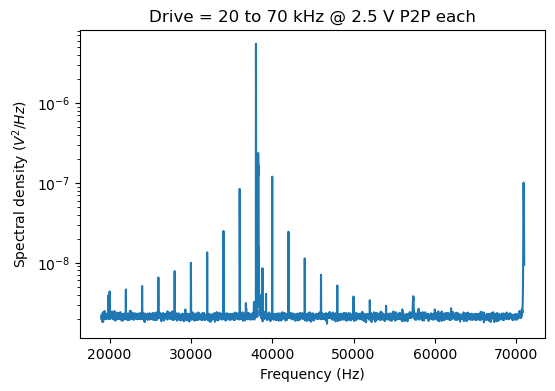

In [223]:
lb, ub = 1900, 7100
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ff[lb:ub], pp[lb:ub])

ax.set_title('Drive = 20 to 70 kHz @ 2.5 V P2P each')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density ($V^2 / Hz$)')

ax.set_yscale('log')

In [224]:
drive_amp = 2.5  # peak-to-peak voltage for each freq component in V
freq_comb_file = r"C:\Users\microspheres\Documents\Python Scripts\Experiment Control\freq_comb_20khz_70khz_deltaf2khz.npz"

comb_data = np.load(freq_comb_file, allow_pickle=True)
ff_drive = comb_data['ff']

In [225]:
charge = 3 * 1.6e-19

efield = 250          # V/m when 1 V is applied
amp = drive_amp / 2   # Because what's in the file is the peak-to-peak amplitude and we want the amp from zero

c_cal_square = 68552553774.39739

In [226]:
chisquare = np.zeros_like(ff_drive, dtype=np.float64)
f0 = charge * amp * efield

for i, f in enumerate(ff_drive):
    v2_drive = get_peak_area(data, 1, f)
    x2_drive = v2_drive / c_cal_square
    
    chisquare_drive = 2 * x2_drive / (f0**2)
    
    chisquare[i] = chisquare_drive

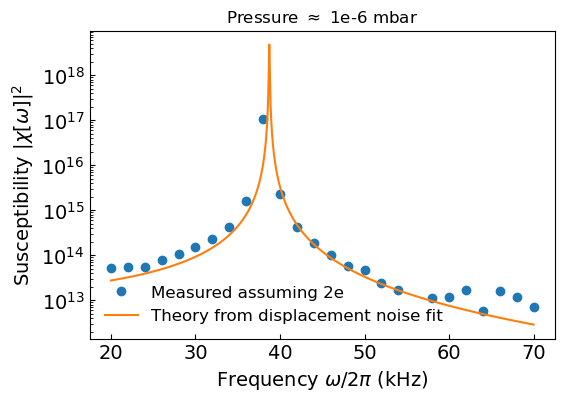

In [227]:
lb, ub = 2000, 7000

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ff_drive/1000, chisquare, 'o', label='Measured assuming 2e')

ax.plot(ff[lb:ub]/1000, peak_func(ff[lb:ub]*2*np.pi, 1/(m * m * gamma_low), omega0_low, gamma_low), label='Theory from displacement noise fit')

ax.set_title(r'Pressure $\approx$ 1e-6 mbar')
ax.set_xlabel(r'Frequency $\omega / 2 \pi$ (kHz)', fontsize=14)
ax.set_ylabel(r'Susceptibility $| \chi[\omega] |^2$', fontsize=14)
ax.legend(loc='lower left', frameon=False, fontsize=12)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
ax.set_yscale('log')

In [213]:
data_file = r"D:\Experiment\Calibration\20230913\89khzonly_1s_lp_3.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

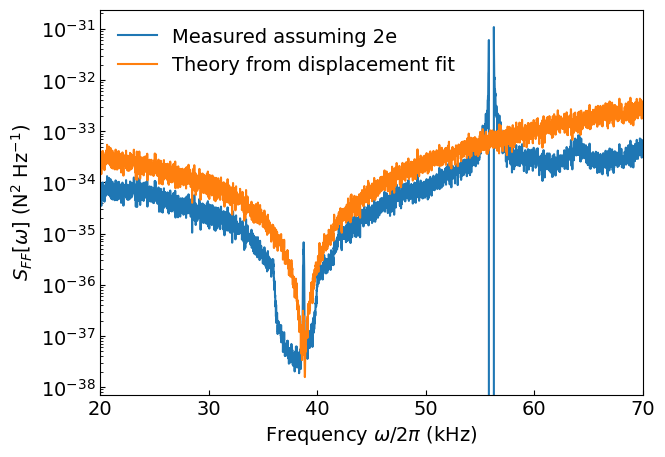

In [214]:
fig, ax = plt.subplots(figsize=(7, 5))

lb, ub = 2000, 7001
sxx = pp / c_cal_square
sff = sxx[lb:ub] / np.interp(ff[lb:ub], ff_drive, chisquare)

ax.plot(ff[lb:ub] / 1000, sff, label='Measured assuming 2e')
ax.plot(ff[lb:ub] / 1000, sxx[lb:ub] / peak_func(ff[lb:ub]*2*np.pi, 1/(m * m * gamma_low), omega0_low, gamma_low), label='Theory from displacement fit')

ax.set_xlim(20, 70)
# ax.set_ylim(1e-41, 1e-34)

ax.set_yscale('log')
ax.set_xlabel(r'Frequency $\omega / 2 \pi$ (kHz)', fontsize=14)
ax.set_ylabel(r'$S_{FF}[\omega]$ (N$^2$ Hz$^{-1}$)', fontsize=14)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
ax.legend(frameon=False, fontsize=14)

## After about five hours

In [245]:
data_file = r"D:\Experiment\Calibration\20230913\89khzonly_1s_lp_5.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

Low Pressure - Amplitude: 1001571.1686783966, central frequency: 38582.21588551687 Hz, gamma: 38.247054109027054 Hz


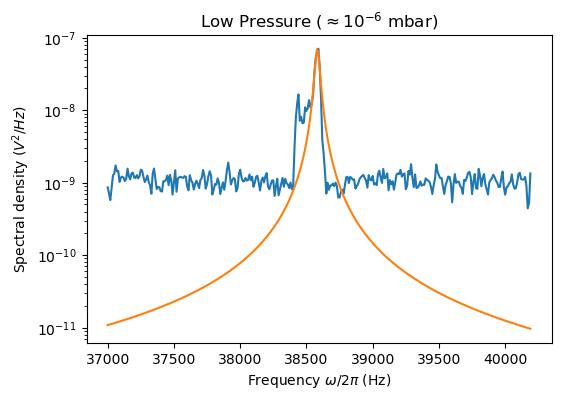

In [246]:
lb, ub = 3700, 4020

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ff[lb:ub], pp[lb:ub])

# Fit with a Lorentzian and plot
popt, omega_fit, p_fit = fit_peak(ff[lb:ub]*2*np.pi, pp[lb:ub], peak_func, p0=[535, 39500*2*np.pi, 500])
ax.plot(omega_fit/(2*np.pi), p_fit)

amp_low, omega0_low, gamma_low = popt[0], popt[1], popt[2]
print(f'Low Pressure - Amplitude: {amp_low}, central frequency: {omega0_low/(2*np.pi)} Hz, gamma: {gamma_low/(2*np.pi)} Hz')

ax.set_title(r'Low Pressure ($\approx 10^{-6}$ mbar)')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)')
ax.set_ylabel('Spectral density ($V^2 / Hz$)')

ax.set_yscale('log')

In [238]:
data_file = r"D:\Experiment\Calibration\20230913\freq_comb_20s_20_70_2khz_lp_1_5vp2p_2ndround_5.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

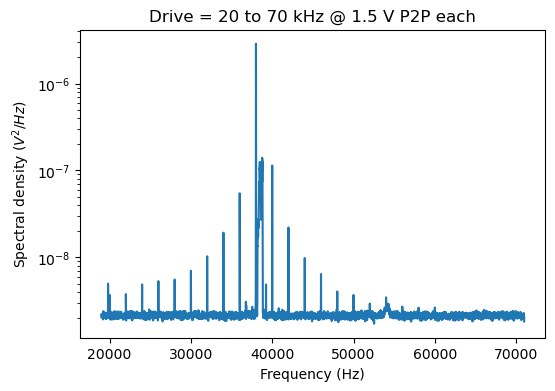

In [239]:
lb, ub = 1900, 7100
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ff[lb:ub], pp[lb:ub])

ax.set_title('Drive = 20 to 70 kHz @ 1.5 V P2P each')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density ($V^2 / Hz$)')

ax.set_yscale('log')

In [240]:
drive_amp = 1.5  # peak-to-peak voltage for each freq component in V
freq_comb_file = r"C:\Users\microspheres\Documents\Python Scripts\Experiment Control\freq_comb_20khz_70khz_deltaf2khz.npz"

comb_data = np.load(freq_comb_file, allow_pickle=True)
ff_drive = comb_data['ff']

In [241]:
charge0 = 2 * 1.6e-19

efield = 250          # V/m when 1 V is applied
amp = drive_amp / 2   # Because what's in the file is the peak-to-peak amplitude and we want the amp from zero

c_cal_square = 68552553774.39739

In [242]:
chisquare = np.zeros_like(ff_drive, dtype=np.float64)
f0 = charge * amp * efield

for i, f in enumerate(ff_drive):
    v2_drive = get_peak_area(data, 1, f)
    x2_drive = v2_drive / c_cal_square
    
    chisquare_drive = 2 * x2_drive / (f0**2)
    
    chisquare[i] = chisquare_drive

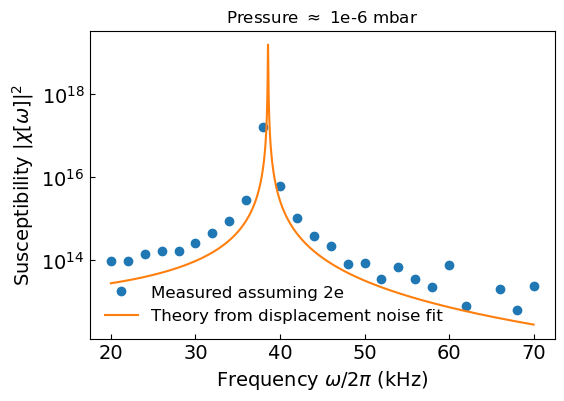

In [243]:
lb, ub = 2000, 7000

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ff_drive/1000, chisquare, 'o', label='Measured assuming 2e')

ax.plot(ff[lb:ub]/1000, peak_func(ff[lb:ub]*2*np.pi, 1/(m * m * gamma_low), omega0_low, gamma_low), label='Theory from displacement noise fit')

ax.set_title(r'Pressure $\approx$ 1e-6 mbar')
ax.set_xlabel(r'Frequency $\omega / 2 \pi$ (kHz)', fontsize=14)
ax.set_ylabel(r'Susceptibility $| \chi[\omega] |^2$', fontsize=14)
ax.legend(loc='lower left', frameon=False, fontsize=12)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
ax.set_yscale('log')

## The next morning

In [228]:
data_file = r"D:\Experiment\Calibration\20230914\89khzonly_1s_lp.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

Low Pressure - Amplitude: 527054.2757896177, central frequency: 39385.98672856596 Hz, gamma: 95.14687683343261 Hz


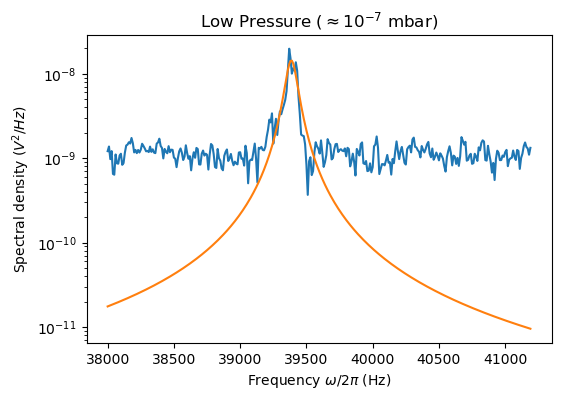

In [229]:
lb, ub = 3800, 4120

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ff[lb:ub], pp[lb:ub])

# Fit with a Lorentzian and plot
popt, omega_fit, p_fit = fit_peak(ff[lb:ub]*2*np.pi, pp[lb:ub], peak_func, p0=[535, 39500*2*np.pi, 500])
ax.plot(omega_fit/(2*np.pi), p_fit)

amp_low, omega0_low, gamma_low = popt[0], popt[1], popt[2]
print(f'Low Pressure - Amplitude: {amp_low}, central frequency: {omega0_low/(2*np.pi)} Hz, gamma: {gamma_low/(2*np.pi)} Hz')

ax.set_title(r'Low Pressure ($\approx 10^{-7}$ mbar)')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)')
ax.set_ylabel('Spectral density ($V^2 / Hz$)')

ax.set_yscale('log')

In [230]:
data_file = r"D:\Experiment\Calibration\20230914\freq_comb_20_70_2khz_1_5vp2p.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

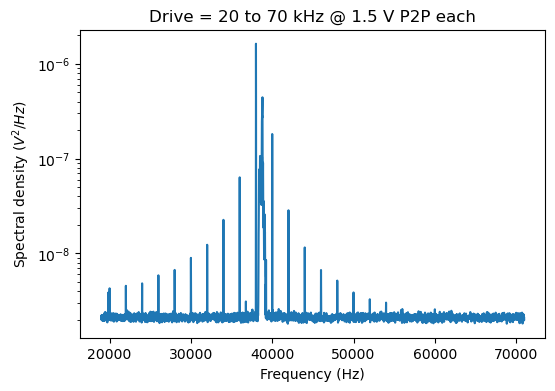

In [231]:
lb, ub = 1900, 7100
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ff[lb:ub], pp[lb:ub])

ax.set_title('Drive = 20 to 70 kHz @ 1.5 V P2P each')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density ($V^2 / Hz$)')

ax.set_yscale('log')

In [232]:
drive_amp = 1.5  # peak-to-peak voltage for each freq component in V
freq_comb_file = r"C:\Users\microspheres\Documents\Python Scripts\Experiment Control\freq_comb_20khz_70khz_deltaf2khz.npz"

comb_data = np.load(freq_comb_file, allow_pickle=True)
ff_drive = comb_data['ff']

In [233]:
charge = 3 * 1.6e-19

efield = 250          # V/m when 1 V is applied
amp = drive_amp / 2   # Because what's in the file is the peak-to-peak amplitude and we want the amp from zero

c_cal_square = 68552553774.39739

In [234]:
chisquare = np.zeros_like(ff_drive, dtype=np.float64)
f0 = charge * amp * efield

for i, f in enumerate(ff_drive):
    v2_drive = get_peak_area(data, 1, f)
    x2_drive = v2_drive / c_cal_square
    
    chisquare_drive = 2 * x2_drive / (f0**2)
    
    chisquare[i] = chisquare_drive

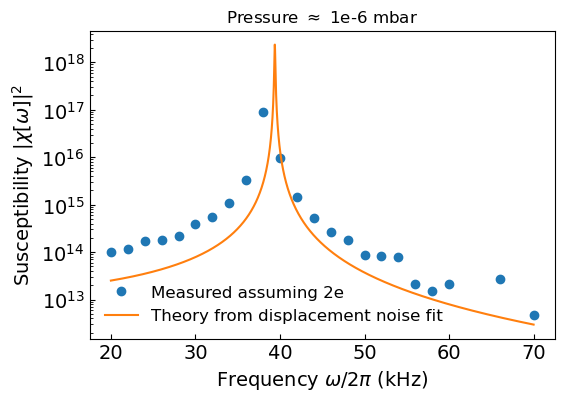

In [235]:
lb, ub = 2000, 7000

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ff_drive/1000, chisquare, 'o', label='Measured assuming 2e')

ax.plot(ff[lb:ub]/1000, peak_func(ff[lb:ub]*2*np.pi, 1/(m * m * gamma_low), omega0_low, gamma_low), label='Theory from displacement noise fit')

ax.set_title(r'Pressure $\approx$ 1e-6 mbar')
ax.set_xlabel(r'Frequency $\omega / 2 \pi$ (kHz)', fontsize=14)
ax.set_ylabel(r'Susceptibility $| \chi[\omega] |^2$', fontsize=14)
ax.legend(loc='lower left', frameon=False, fontsize=12)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
ax.set_yscale('log')